# morph-var 1

## Extract landform normal profiles from a DEM

This is the first of five notebooks outlining the algorithm we used to quantify the morphologic variability of a linear landform. In this notebook, we extract landform-normal profiles using three user-provided data: a DEM of the region of interest, a polygon shapefile that can be used to crop the DEM to the sepecific lanform if desired, and a line shapefile (contained within the cropping polygon) that traces the center of the landform.

The output of the notebook is a folder with text files for each landform-normal profile. Each text file has columns for the Easting, Northing, UTM Zone, and elevation of each point along the landform-normal profile. These text files are used as the data input for notebook 2.

A note: we use [PyOSP](https://pyosp.readthedocs.io/en/latest/), a topographic swath toolbox, to easily obtain the scarp-normal profile coordinates. Please consult their [installation recommendations](https://pyosp.readthedocs.io/en/latest/user_guide/installation.html). 

*Y. Zhu, J.M. Dortch, M.A. Massey, et al., An Intelligent Swath Tool to Characterize complex Topographic Features: Theory and Application in the Teton Range, Licking River, and Olympus Mons, Geomorphology (2021), https://doi.org/10.1016/j.geomorph.2021.107778*

### Packages and libraries

In [3]:
import pyosp 
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping,Point, LineString
import os

### Load DEM, crop extent polygon shapefile, and lanform trace shapefile

In [52]:
# Define paths for DEM, cropping polygon shapefile, and landform trace line shapefile. 
dem_path = "/Users/cassandrabrigham/Documents/RESEARCH/2022/Manuscript/Manuscript 3/GIS/Point_clouds/KauDesert/output-tin.tif"
crop_polygon_path="/Users/cassandrabrigham/Documents/RESEARCH/2022/Manuscript/Manuscript2/Figures/Sites/Hawaii/Kau Desert/kau-poly.shp"
landform_trace_path = "/Users/cassandrabrigham/Documents/RESEARCH/2022/Manuscript/Manuscript2/Figures/Sites/Hawaii/Kau Desert/kau-line.shp"
landform_name='KauDesert'
dem_resolution=1

In [53]:
# Crop DEM to specific area of interest and save cropped DEM. The coordinate reference system (CRS) of the newly created cropped DEM will be defined by the CRS of the cropping polygon shapefile. Please ensure that the chosen CRS is in the Universal Transverse Mercator (UTM) system. 
dem = rxr.open_rasterio(dem_path,masked=True).squeeze() # 
crop_polygon = gpd.read_file(crop_polygon_path)
dem_clipped = dem.rio.clip(crop_polygon.geometry.apply(mapping), crop_polygon.crs)
dem_clipped_path ="dem_clipped.tif"
dem_clipped.rio.to_raster(dem_clipped_path)

### Use PyOSP to extract profiles along the landform

PyOSP will extract profiles that are perpendicular to the landform trace shapefile (input 1: landform_trace_path) from the clipped DEM (input 2: dem_clipped_path). The width of the profiles can be adjusted (input 3: width = 1000 m) to suitably capture the landform. If the width is higher than the extent of the clipped polygon, the length of the profiles will simply be set by the width of the clipped DEM. Therefore, if your cropping polygon outlines your profile in detail, you can use a high width value to ensure that the entirety of the clipped DEM will be used. If your cropping polygon is coarser, you might want to adjust the width to capture the specific landform of interest. Filtering by elevation is possible (input 4: min_elev = 0 m) to limit any DEM value errors. The spacing between profiles along the landform is by default set to the DEM resolution, but can also be adjusted to any value in meters (input 5: line_stepsize = dem_resolution).

In [48]:
elev = pyosp.Elev_curv(landform_trace_path, dem_clipped_path, width=2000, min_elev=0,
                       line_stepsize=dem_resolution, cross_stepsize=None)

Processing: [#########################] 13709 of 13709 lineSteps

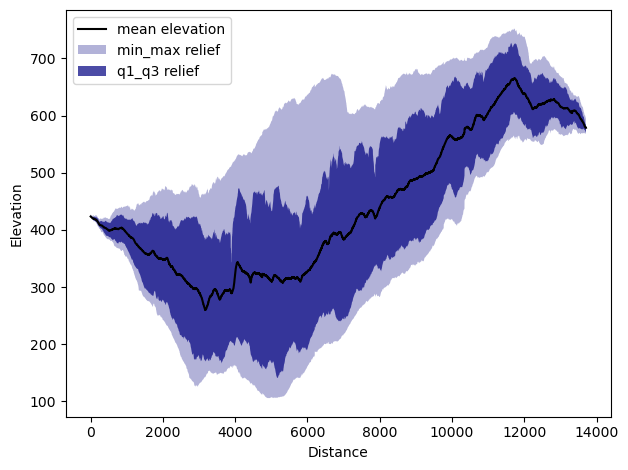

In [49]:
# Check the swath profile plot for any issues.
elev.profile_plot()

In [50]:
crop_polygon.crs

<Projected CRS: EPSG:32605>
Name: WGS 84 / UTM zone 5N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 156°W to 150°W - by country
- bounds: (-156.0, 0.0, -150.0, 84.0)
Coordinate Operation:
- name: UTM zone 5N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
path_shapefile="profile_shapefile/"+landform_name+"_profile_lines.shp"

profile_lines=[]
for a in range(0,len(elev.lines)):
    line_dat=elev.lines[a]
    coords=[(coord[0], coord[1]) for coord in line_dat]
    #points= [Point(coord[0], coord[1]) for coord in line_dat]
    lines=LineString(coords)
    profile_lines.append(lines)
prof_number=np.array(range(0,len(elev.lines)))
distance=prof_number*dem_resolution

d = {'col1': prof_number,'col2': distance, 'geometry': profile_lines}
df=gpd.GeoDataFrame(d,geometry='geometry',crs=crop_polygon.crs)
df.to_file(path_shapefile)

In [ ]:
crop_polygon.crs

In [21]:
len(df)

768

### Extract profile coordinates and store in text files

In [43]:
# Create a folder for text files of the profile coordinates 
path=landform_name+'_raw_profiles/'
if os.path.exists(path)==False: 
    os.mkdir(path)

In [44]:
# Create a list of file names for each profile that includes the landform name and the position of the profile along the landform.
profile_numbers=list(range(0,len(elev.distance)))
profile_filenames=[landform_name+'_'+f'{a}'.zfill(6)+'.txt' for a in profile_numbers]

# Save profile files in newly created folders. The information is stored in 4 columns: Easting coordinate (m), Westing coordinate (m), elevation (m) and CRS (espg code).
for a in profile_numbers:
    elevation_temp = elev.dat[a]
    x_coord_temp=[elev.lines[a][b][0] for b in list(range(0,len(elev.lines[a])))]
    y_coord_temp=[elev.lines[a][b][1] for b in list(range(0,len(elev.lines[a])))]
    
    x_coord=pd.Series(x_coord_temp)
    y_coord=pd.Series(y_coord_temp)
    elevation=pd.Series(elevation_temp)
    
    landform_profile_info = pd.concat([x_coord,y_coord,elevation],axis=1)
    landform_profile_info.columns=('Easting','Westing','elevation')
    
    landform_profile_crs=pd.Series(crop_polygon.crs,name='CRS')
    landform_profile_info=pd.concat([landform_profile_info,landform_profile_crs],axis=1)
    
    file=profile_filenames[a]
    landform_profile_info.to_csv(path+file)